# Dimension and Fractals 1: Koch Curve

It is often easier to understand fractal dimension by looking at linear shapes, like a coastline.
The Koch Curve is a famous fractal that can help us understand what it means to measure with different sized "rulers", and about the relation between the measurement scale used and the total measured length - this relationship is called ["fractal dimension"](https://en.wikipedia.org/wiki/Fractal_dimension).

#### Introduction to Fractal Dimension
I **highly** recommend you start with this [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4)

-------------------

As usual, the first code block just imports the modules we will use.

In [116]:
%matplotlib inline

import math
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.stats import linregress

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
The Point2D class we examined previously plus a couple small helpers for re-arranging iterables...

In [117]:
class Point2D:
    """ A point on the 2D Cartesian plane """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return '({x}, {y})'.format(x=round(self.x,2), y=round(self.y,2))

    def __add__(self, other):
        return Point2D(self.x+other.x, self.y+other.y)

    def distance(self, other):
        """ Return distance between this point and other Point2D """
        return math.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)

    def angle(self, other):
        """ return the angle of the line segment running between self and other """
        return np.arctan2(other.y-self.y, other.x-self.x)

    def mid(self, other, p=0.5):
        """" return a new point mid way on the line segment between self and other, p-way along the segment """
        return Point2D(self.x + (other.x-self.x)*p, self.y + (other.y-self.y)*p)


class PolarPoint2D(Point2D):
    """ A point on the 2D Cartesian plane specified in polar coordinates """
    def __init__(self, r, theta):
        """ define point by length r and angle, theta, in radians """
        super().__init__(x=r*np.cos(theta), y=r*np.sin(theta))


def flatten(container):
    """ return generator with items from an iterable of iterables """
    return (item for iterable in container for item in iterable)
assert tuple( flatten([(1,2,3), (4,), (5,6)]) ) == (1,2,3,4,5,6)

## Fractal Dimension

  The essential idea of "fractured" dimensions has a long history in mathematics, but the term itself was brought to the fore by *Benoit Mandelbrot* based on his 1967 paper on self-similarity in which he discussed fractional dimensions.
  In that paper, Mandelbrot cites work by Lewis Fry Richardson describing the counter-intuitive notion that a coastline's measured length changes with the length of the measuring stick used... [**_https://en.wikipedia.org/wiki/Fractal_dimension_**](https://en.wikipedia.org/wiki/Fractal_dimension)

### Koch Snowflake

   One non-trivial example is the fractal dimension of a Koch snowflake. It has a topological dimension of 1, but it is by no means a rectifiable curve: the length of the curve between any two points on the Koch snowflake is infinite. No small piece of it is line-like, but rather it is composed of an infinite number of segments joined at different angles. The fractal dimension of a curve can be explained intuitively thinking of a fractal line as an object too detailed to be one-dimensional, but too simple to be two-dimensional. Therefore its dimension might best be described not by its usual topological dimension of 1 but by its fractal dimension, which is often a number between one and two; in the case of the Koch snowflake, it is about 1.262  [**_https://en.wikipedia.org/wiki/Koch_snowflake_**](https://en.wikipedia.org/wiki/Koch_snowflake)

In [118]:
# A little geometry to split a line segment (p1, p1) into a triangle, (p1, tri_point, p2)
RIGHT_ANGLE = np.pi / 2
TRI_ANGLE  = np.pi / 3             # interior angle of an equilateral triangle
TAN_TRI_ANGLE = np.tan(TRI_ANGLE)  # re-usable quantity:  tan( 60 )

def eq_tri_point(p1, p2, scale=1):
    """
    Return the point perpendicular to mid-point of line segment p1:p2 that forms
    an equilateral triangle, scaled by given factor (where 1 scales triangle to edge length p1.distance(p2)
    """
    return p1.mid(p2) + PolarPoint2D(r=TAN_TRI_ANGLE * p1.distance(p2) * scale/2, theta=p1.angle(p2) + RIGHT_ANGLE)


class KochCurve:
    """ A single Koch curve """

    def __init__(self, degree=0, size=9):
        """ A koch curve scaled to given length - degree 0 (straight line) by default """
        self.degree = degree
        self.size = size
        self.title = "Koch Curve"
        self.lines = [self._initial_state(size), ]
        self.step(self.degree)

    def _initial_state(self, size):
        """ Helper: get a tuple of initial points defining the line segment(s) on the curve """
        # vertices of a straight line segment
        A = Point2D(0, 0)
        B = Point2D(size, 0)

        # A "curve" is just a tuple of Point2D objects - this one is a single line segment
        return (A, B)

    def koch_curve(self, p1, p2):
        """ return 5-tuple of points on the first-degree koch curve between p1 and p2 """
        return (
            p1, p1.mid(p2, 1/3), eq_tri_point(p1, p2, scale=1/3), p1.mid(p2, 2/3), p2
        )

    def step(self, degree=1):
        """ make the snowflake n degrees more fractal """
        for d in range(degree):
            # replace each line segment with a koch curve
            new_lines = []
            for line in self.lines:
                new_lines += [self.koch_curve(p1, p2) for p1,p2 in zip(line, line[1:])]
            self.lines = new_lines

    def get_points(self):
        """ return a generator for all the points currently calculated on this curve """
        return flatten(self.lines)

    def n_segs(self):
        """ return the number of line segments currently calculated on this curve """
        return sum(1 for _ in self.get_points()) - len(self.lines)  # 1 fewer segments than points in each line

    def draw(self, ax, step=''):
        """ Draw the curve on the given axes """
        ax.clear()
        ax.set_title(f'{self.title}, degree: {step or self.degree}')
        ax.axis('equal')
        x, y = zip(*((p.x, p.y) for p in self.get_points()))
        ax.plot(x, y)


class KochSnowflake(KochCurve):
    """ 3 Koch curves connected in an equilateral triangle form a Koch snowflake """

    def __init__(self, degree=0, size=9):
        """ A koch snowflake scaled to given size - degree 0 (triangle) by default """
        super().__init__(degree, size)
        self.title = "Koch Snowflake"

    def _initial_state(self, size):
        """ Helper: get a tuple of initial points defining the line segment(s) on the curve """
        # An equilateral triangle
        A = Point2D(0, 0)
        B = Point2D(size, 0)
        C = eq_tri_point(A, B)

        #  initial curve is a tuple of Point2D objects defining the segments of the triangle, counter-clockwise
        return (A, C, B, A)

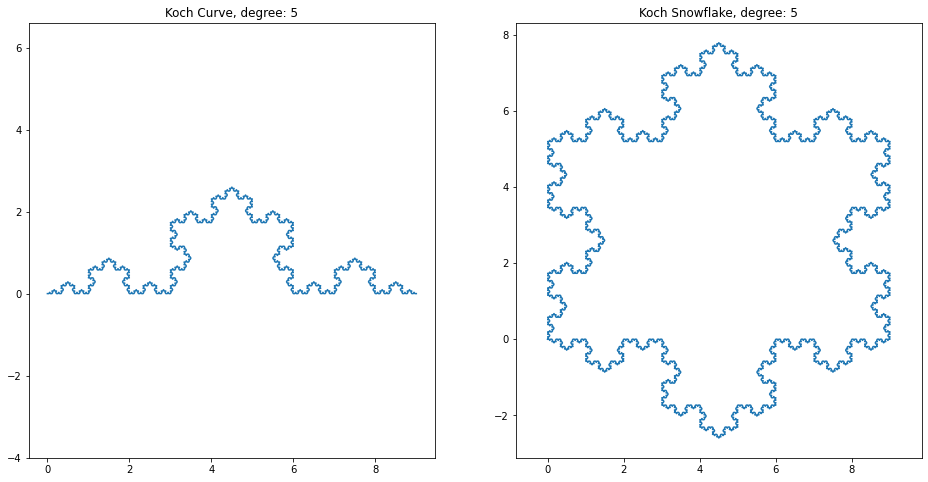

In [119]:
# Generate and plot a sample curve and snowflake with same degree
degree = 5
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

curve= KochCurve(degree=degree)
curve.draw(axes[0])

snowflake = KochSnowflake(degree=degree)
snowflake.draw(axes[1])
plt.show()

### Koch Animation
using our trusty 2D Animation class... really got to get this into a re-usable library :-)

In [120]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [121]:
# Create the animation - careful, somewhere above degree 8 the number of points gets very large!
degree = 5
anim = Animation2D(KochSnowflake(), frames=degree+1)
anim.show()

## Dimension of Koch Curve

Any koch curve can be divided into 4 self-similar segments, each 1/3 the length of the original.

#### Based on: [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4):

**Mass Scaling factor** is 4 : each curve can be broken down into 4 self-similar curves...
**Size Scaling factor** is 3 : where each sub-curve will be exactly 1/3 the size of the original

Because we know the mass and length scaling factors for a Koch curve, we can simply calculate it's fractal dimension $D$:

Dimensionality relation: $(1/3)^D == 1/4$
yields $D = log_3(4)$

In [122]:
D = math.log(4, 3)
f'Fractal dimension of a Koch Curve is {round(D, 2)}'

'Fractal dimension of a Koch Curve is 1.26'

## Estimating the fractal dimension of a shape with a scaling "measuring stick"

But what if we didn't know the mass and length scaling factors ahead?  How might we measure the fractal dimension directly?

**Lewis Fry Richardson** (1881-1953), an English meteorologist, pioneered a process for calculating dimensions with varied measurements. Using this technique an object's perimeter is measured with rulers of different lengths, then by graphing its slope the corresponding dimension is calculated. See [Calculating Fractal Dimension](https://www.wahl.org/fe/HTML_version/link/FE4W/c4.htm#richardson)

The length of a koch curve is proportional to the number of line segments, so a naturals set of "rulers" would be the lengths of line segments at each successive degree of the curve (1, 1/3, 1/9, 1/27, ...)

In [123]:
max_degree = 8
degrees = np.array(range(max_degree+1))
koch_rulers= tuple(1 / 3**d for d in degrees)
f'Rulers used to measure length of curve: {koch_rulers}'

'Rulers used to measure length of curve: (1.0, 0.3333333333333333, 0.1111111111111111, 0.037037037037037035, 0.012345679012345678, 0.00411522633744856, 0.0013717421124828531, 0.0004572473708276177, 0.00015241579027587258)'

In [124]:
def num_koch_segments(max_degree):
    """
    Return a vector with the number of line segments for each degree koch curve from 1 to .. max
    This is equivalent to measuring a max_degree curve with ruler lengths 1, 1/3, 1/9, 1/27, ...
    """
    curve = KochCurve()
    n_segs = [curve.n_segs(), ]
    for degree in range(1,max_degree+1):
        curve.step()
        n_segs.append(curve.n_segs())
    return n_segs

n_segments = num_koch_segments(max_degree)
print('Number of segments measured by ruler length:')
dict((deg, n) for deg, n in zip(koch_rulers, n_segments))

Number of segments measured by ruler length:


{1.0: 1,
 0.3333333333333333: 4,
 0.1111111111111111: 16,
 0.037037037037037035: 64,
 0.012345679012345678: 256,
 0.00411522633744856: 1024,
 0.0013717421124828531: 4096,
 0.0004572473708276177: 16384,
 0.00015241579027587258: 65536}

As expected, we see that as the length scale is divided by a factor of $3$, the perimeter of the curve increases by a factor of $4$.
Naturally, since with each successively smaller "ruler" we measure 4 curves for each curve measured at the next larger scale.

#### Plot perimeter length (number of line segments measured) against length scale (size of ruler)

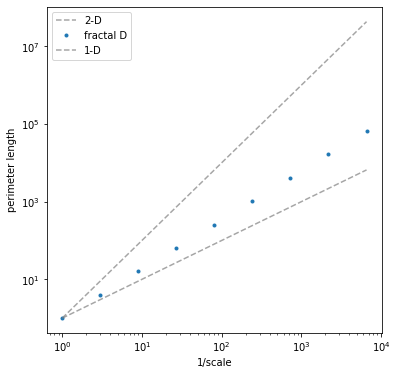

In [125]:
def plot_scaling(length_scales, perimeter_lengths):
    """
    Plot the measured perimeter length (mass) against the inverse length scale (ruler) used to measure it
    Compare this plot to 1D (y = x) and 2D (y = x**2) scaling factors
    """
    assert len(length_scales) == len(perimeter_lengths)

    plot_options = dict(xlabel='1/scale', ylabel='perimeter length', xscale='log', yscale='log')
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=plot_options)

    # use 1/length scale for x-axis so it plots nicely
    xs = 1 / np.array(length_scales)

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    ax.plot(xs, xs**2, label='2-D', **line_options)          # y =  x**2
    ax.plot(xs, perimeter_lengths, '.', label='fractal D')   # y = perimeter length for length scale, x
    ax.plot(xs, xs, label='1-D', **line_options)             # y = x
    ax.legend()

plot_scaling(koch_rulers, n_segments)

The slope of these lines gives an estimate of their dimension because it is the ratio of how mass and length scale together.
A [linear regression](https://en.wikipedia.org/wiki/Linear_regression) estimates the slope (and other properties) of a line...

In [126]:
# compute the slope of these 3 lines (square, koch perimeter, linear) to estimate their dimension (using linear regression)
xs = 1 / np.array(koch_rulers)
for label, ys in [('square', xs ** 2), ('koch  ', np.array(n_segments)), ('linear', xs)]:
    slope,*_ = linregress(np.log(xs), np.log(ys))
    print(f'{label} dimension: {slope}')

square dimension: 2.0
koch   dimension: 1.2618595071429148
linear dimension: 1.0
